In [3]:
import torchvision
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_name())
print(torch.__version__)
print(torch.version.cuda)
x = torch.randn(1).cuda()
print(x)

NVIDIA GeForce RTX 3050 Ti Laptop GPU
2.4.0+cu124
12.4
tensor([0.5610], device='cuda:0')


In [33]:
torch.manual_seed(17)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(8/9, 9/8)),
        torchvision.transforms.ToTensor(),
    ]
)

val_augs = torchvision.transforms.Compose(
    [
        transforms.Resize(224),
        torchvision.transforms.ToTensor(),
    ]
)

In [7]:
pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [8]:
pretrained_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
finetuned_net = nn.Sequential(
    pretrained_net,
    nn.ReLU(),
    nn.Linear(1000, 2),
)

In [19]:
import time
import copy

train_losses = []
val_losses = []

def train_model(
    model, dataloaders, criterion, optimizer, num_epochs=25
):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)


            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'side_recognition_model.pth')
            if phase == "val":
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [20]:
import os

data_dir = "images_by_side"
batch_size = 24

model_ft = finetuned_net.to(device)
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "train"), transform=train_augs
    ),
    batch_size=batch_size,
    shuffle=True,
)
val_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "val"), transform=val_augs
    ),
    shuffle=True,
    batch_size=batch_size,
)
loss = nn.CrossEntropyLoss(reduction="none")

In [21]:
def train_fine_tuning(net, learning_rate, num_epochs=15):

    trainer = torch.optim.SGD([{"params": finetuned_net[2].parameters(), "lr": learning_rate * 10}], lr=learning_rate)

    dataloaders_dict = {"train": train_iter, "val": val_iter}
    criterion = nn.CrossEntropyLoss()
    model_ft, hist = train_model(
        net, dataloaders_dict, criterion, trainer, num_epochs=num_epochs
    )
    return model_ft, hist


In [22]:
model_ft, hist = train_fine_tuning(model_ft, learning_rate=5e-3)

Epoch 1/15
----------


KeyboardInterrupt: 

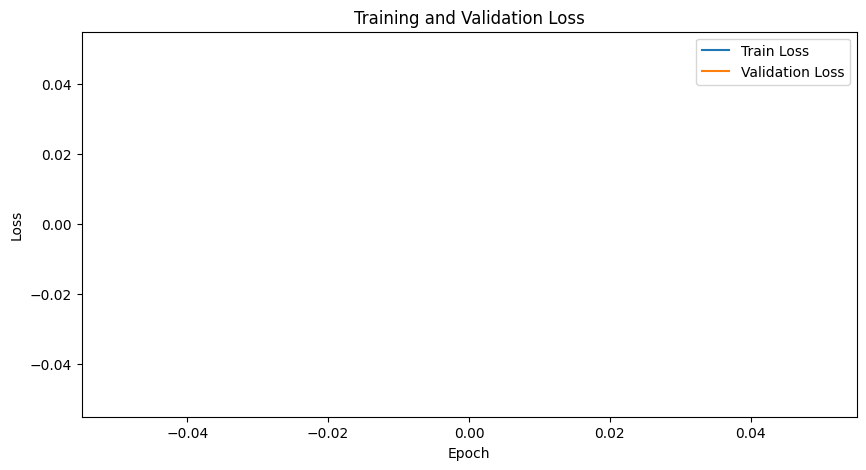

In [23]:
starting_epoch = 1
y = list(range(starting_epoch, len(train_losses)))
plt.figure(figsize=(10, 5))
plt.plot(y, train_losses[starting_epoch:], label='Train Loss')
plt.scatter(y, train_losses[starting_epoch:])
plt.plot(y, val_losses[starting_epoch:], label='Validation Loss')
plt.scatter(y, val_losses[starting_epoch:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('loss.png')

In [24]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [34]:
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)

    return predicted.item(), image.cpu().squeeze()

def visualize_prediction(image_path, model, transform, class_names):
    predicted_class, image_tensor = predict_image(image_path, model, transform)
    # plt.figure(figsize=(6, 6))
    # imshow(image_tensor, title=f'Predicted: {class_names[predicted_class]}')
    # plt.show()
    return class_names[predicted_class]

def visualize_predictionWithImage(image_path, model, transform, class_names):
    predicted_class, image_tensor = predict_image(image_path, model, transform)
    plt.figure(figsize=(6, 6))
    imshow(image_tensor, title=f'Predicted: {class_names[predicted_class]}')
    plt.show()
    return class_names[predicted_class]

image_path = 'images_by_side/train/right/13c2ur549vohc0jat2dvu3xrxb1_27.png'

class_names = ["left", "right"]



C:\Users\wikto\AppData\Local\Temp\ipykernel_24552\4043550164.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_from_file.load_state_dict(torch.load('side_recognition

131aedfhs6pnf1fvtvp49ml751k6d75922_39.png


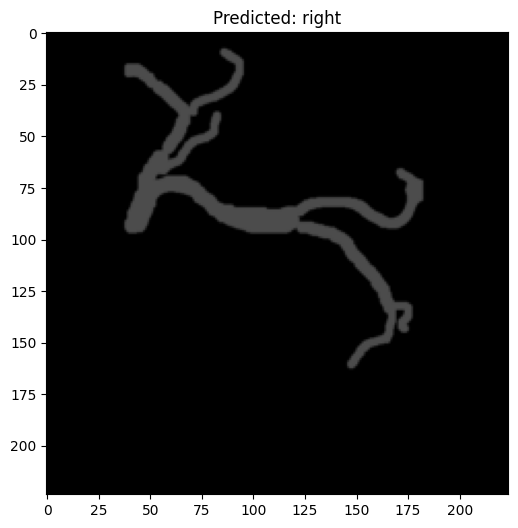

In [42]:
import os
model_from_file = finetuned_net.to(device)
model_from_file.load_state_dict(torch.load('side_recognition_model.pth'))

directory_path = 'images_by_side/test/left'

file_names = os.listdir(directory_path)
file_names = [f for f in file_names if os.path.isfile(os.path.join(directory_path, f))]

class_names = ["left", "right"]

for file_name in file_names:
    image_path = os.path.join(directory_path, file_name)
    predicted_class = visualize_prediction(image_path, model_ft, val_augs, class_names)
    if predicted_class == "right":
        print(file_name)
        visualize_predictionWithImage(image_path, model_ft, val_augs, class_names)


In [39]:
print(len(file_names))

50
